In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15584182012539602190
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4834983936
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16088839027929111404
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [3]:
import os

import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from PIL import ImageFont
import visualkeras

In [4]:
"""all_img_names = []
for dirname, _, filenames in os.walk('combined_faces/'):
    for filename in filenames:
        all_img_names.append( os.path.join(dirname, filename))
"""
img_dir = "part1"

all_img_names=os.listdir(img_dir)

print('Total images ', len(all_img_names))

Total images  3136


In [5]:
all_img_names[500:510]

['12_168.jpg',
 '12_169.jpg',
 '12_17.jpg',
 '12_170.jpg',
 '12_171.jpg',
 '12_172.jpg',
 '12_173.jpg',
 '12_174.jpg',
 '12_175.jpg',
 '12_176.jpg']

In [6]:
seed_constant = 27
random.seed(seed_constant)

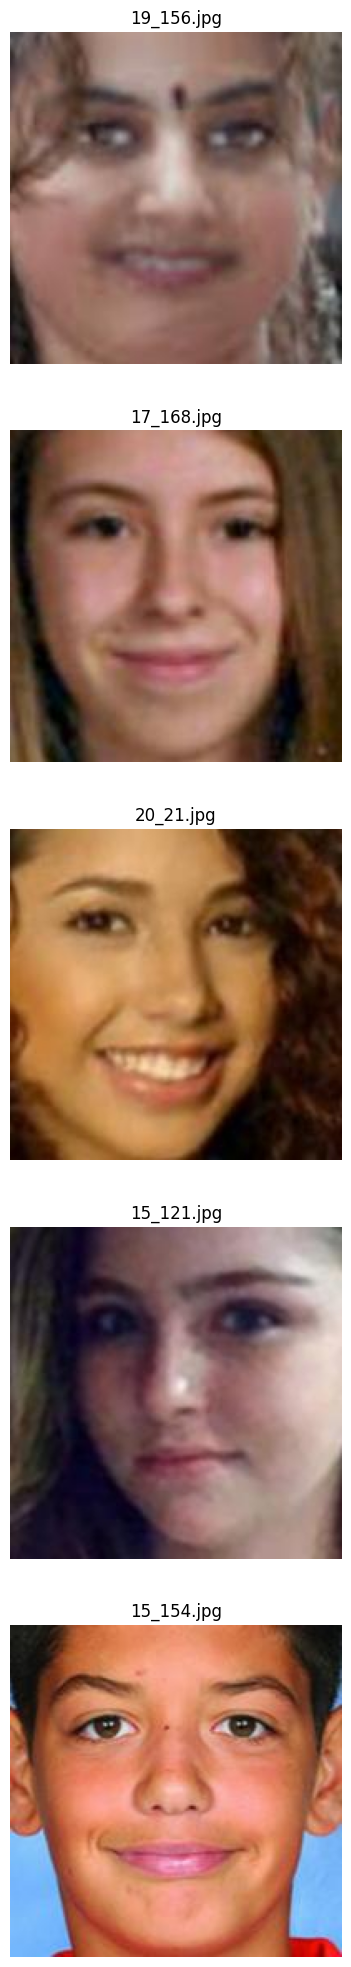

In [7]:
# Create a Matplotlib figure.
plt.figure(figsize=(25,25))

# Generate a list of 5 random values. The values should be less than number of images in dataset.
random_range = random.sample(range(len(all_img_names)), 5)

#Iterate through random values
for counter, random_index in enumerate(random_range, 1):
  
  #Name of the selected image
  img_name=all_img_names[random_index]

  #Path of the selected image
  img_path=os.path.join(img_dir,img_name)

  #Read the selected image in BGR format
  bgr_img=cv2.imread(img_path)

  #Convert it into RGB format
  rgb_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)

  #Display the selected image
  plt.subplot(5, 1, counter)
  plt.imshow(rgb_img)
  plt.title(img_name)
  plt.axis('off')

# Pre-process the Dataset


In [8]:
img_height=224
img_width=224

In [9]:
def image_preprocessing(img_path):
    
    
    #Read the image
    img=cv2.imread(img_path)
    
    #Resize the image 
    resized_img=cv2.resize(img,(img_height,img_width))
    
    #Normalize the image
    normalized_img=resized_img/255
    
    return normalized_img

In [10]:
def label_extraction(img_name):
    
    '''
    This function will extract age from image name and return the class index by performing integer division (by 25).
    Args:
        img_name: The name of the image.
    Returns:
        class_index: An integer representing the age class.
    '''
    #Extract age 
    age=int(img_name.split("_")[0])
    
    #Class index dividing by 25
    class_index=age//25
    
    
    return class_index

In [11]:
def create_dataset():    
    
    #Declare empty lists to store features and labels.
    
    features=[]
    labels=[]
    
    for img_name in all_img_names:
        
        #Path of the image
        img_path=os.path.join(img_dir,img_name)
            
        #Get the preprocessed image
        preprocessed_img=image_preprocessing(img_path)
            
        #Get the class index
        class_index=label_extraction(img_name)
            
        #Append data into appropriate lists
        features.append(preprocessed_img)
        labels.append(class_index)
        
            
    #Convert lists to numpy arrays
    features=np.asarray(features)
    labels=np.asarray(labels)
    
    return features,labels

In [12]:
#Create the dataset
features,labels=create_dataset()

In [13]:
print(labels[40:48],features[:3])

[0 0 0 0 0 0 0 0] [[[[0.         0.00392157 0.03529412]
   [0.         0.         0.03529412]
   [0.         0.         0.04705882]
   ...
   [0.41176471 0.47843137 0.60784314]
   [0.40392157 0.4627451  0.59215686]
   [0.39607843 0.45490196 0.58431373]]

  [[0.         0.         0.03137255]
   [0.03921569 0.04313725 0.08235294]
   [0.01176471 0.01960784 0.06666667]
   ...
   [0.40392157 0.47058824 0.59607843]
   [0.4        0.45882353 0.58823529]
   [0.4        0.4627451  0.58823529]]

  [[0.         0.         0.03529412]
   [0.01176471 0.01568627 0.05490196]
   [0.00392157 0.00784314 0.05882353]
   ...
   [0.39607843 0.4627451  0.59215686]
   [0.4        0.4627451  0.59215686]
   [0.40784314 0.4745098  0.60392157]]

  ...

  [[0.85490196 0.83137255 0.8745098 ]
   [0.83529412 0.81176471 0.85490196]
   [0.82745098 0.80392157 0.84705882]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.85098039 0.82745098 0

In [14]:
encoded_labels=np_utils.to_categorical(labels)

In [15]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,
                                                                            test_size = 0.1, shuffle = True,
                                                                            random_state = seed_constant)

In [16]:
#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers 
for layer in vgg.layers:
  layer.trainable = False

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

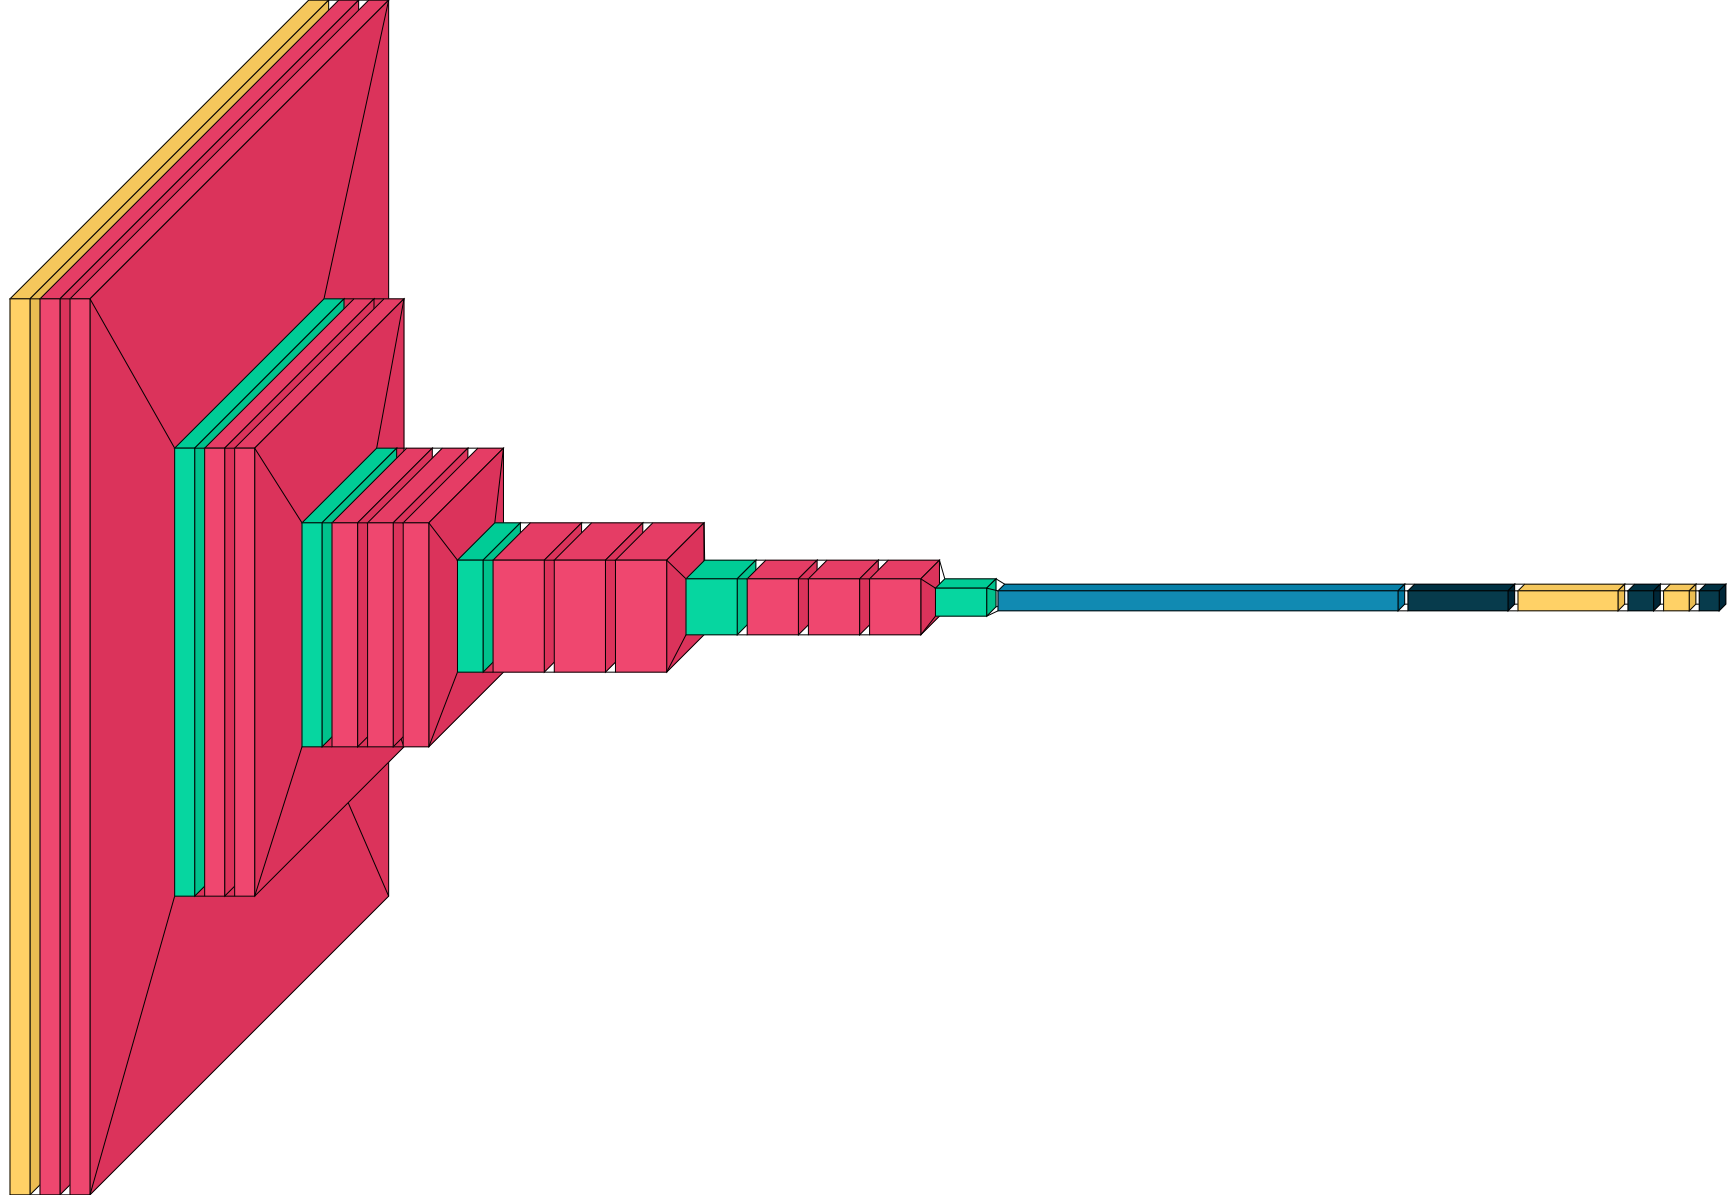

In [17]:
#selected font
arialtf = "font/arial.ttf"
font = PIL.ImageFont.truetype(arialtf, 32)
visualkeras.layered_view(model, font=font)

In [18]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs = 50, 
                    shuffle = True, validation_split = 0.1, 
                    callbacks = callbacks_list )

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to weights.best.hdf5
80/80 [==============================] - 60s 450ms/step - loss: 0.2334 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 2.9873e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
80/80 [==============================] - 21s 266ms/step - loss: 2.9873e-04 - accuracy: 1.0000 - val_loss: 2.2202e-07 - val_accuracy: 1.0000
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 3.7315e-08 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
80/80 [==============================] - 21s 265ms/step - loss: 3.7315e-08 - accuracy: 1.0000 - val_loss: 6.5728e-11 - val_accuracy: 1.0000
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 9.7732e-12 - accuracy: 1.0000
Epoch 4: va

In [19]:
# load weights of model with best validation accuracy
model.load_weights("weights.best.hdf5")

In [20]:
model_evaluation_history_base = model.evaluate(features_test, labels_test)

10/10 [==============================] - 8s 883ms/step - loss: 0.0023 - accuracy: 1.0000


In [21]:
model_evaluation_history = model.evaluate(features_test, labels_test)

10/10 [==============================] - 2s 224ms/step - loss: 0.0023 - accuracy: 1.0000


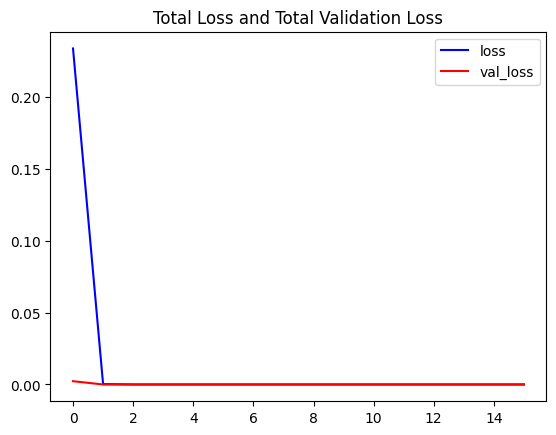

In [22]:
# Construct a range object 
epochs = range(len(history.history["loss"]))
# Plot the Graph.
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
# Add title 
plt.title("Total Loss and Total Validation Loss")
# Add legend 
plt.legend()

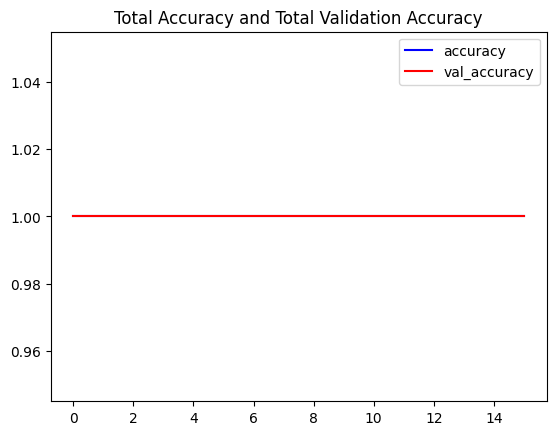

In [23]:
# Construct a range object 
epochs = range(len(history.history["accuracy"]))
# Plot the Graph.
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
# Add title 
plt.title("Total Accuracy and Total Validation Accuracy")
# Add legend 
plt.legend()